In [22]:
#https://stackoverflow.com/questions/44225771/scraping-historical-data-from-yahoo-finance-with-python
import re
import gc
from io import StringIO
from datetime import datetime, timedelta
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [18]:
# Define function to get historical stock data from Yahoo finance
class YahooFinanceHistory:
    timeout = 2
    crumb_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1d&events=history&crumb={crumb}'

    def __init__(self, symbol, date_from):
        self.symbol = symbol
        self.session = requests.Session()
        #self.dt = timedelta(days=days_back)
        self.dt = datetime.strptime(
            date_from, '%m/%d/%Y'
        )  # New. Only interest in data started from the begining of 2020

    def get_crumb(self):
        response = self.session.get(self.crumb_link.format(self.symbol),
                                    timeout=self.timeout)
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError('Could not get' + str(self.symbol) +
                             'from Yahoo Finance')
        else:
            self.crumb = match.group(1)

    def get_quote(self):
        if not hasattr(self, 'crumb') or len(self.session.cookies) == 0:
            self.get_crumb()
        now = datetime.utcnow()
        dateto = int(now.timestamp())
        # datefrom = int((now - self.dt).timestamp()) -- original
        datefrom = int(self.dt.timestamp())  # New
        url = self.quote_link.format(quote=self.symbol,
                                     dfrom=datefrom,
                                     dto=dateto,
                                     crumb=self.crumb)
        response = self.session.get(url)
        response.raise_for_status()
        return pd.read_csv(StringIO(response.text), parse_dates=['Date'])
    
    def get_Min_and_Max(self):
        """ 
        Return a list of Max/Min/Last Pricing information in a list
        """ 
        try:
            df = self.get_quote()
            closeMax = df.iloc[df['Close'].idxmax()] 
            closeMin = df.iloc[df['Close'].idxmin()] 
            closeCurrent = df.iloc[-1,:]
            result = [self.symbol,
                     closeMax['Date'].date(), # Date of highest closing price 
                     closeMax['Close'],       # Max closing price 
                     closeMin['Date'].date(), # Date of lowest closing price
                     closeMin['Close'],       # Min closing Price
                     closeCurrent['Date'].date(), # Last Close price
                     closeCurrent['Close'],    # Last Close Price
                     round((closeMin['Close'] - closeMax['Close'])/closeMax['Close'], 4), # Precent change from high to low
                     round((closeCurrent['Close'] - closeMax['Close'])/closeMax['Close'], 4) # Precent change from high to current
                    ]

            # Remove varible
            del df
            del closeMax
            del closeMin
            del closeCurrent
            gc.collect()

            return result

        except: 
            print('Could not get ' + str(symbol) + ' from Yahoo Finance')

In [13]:
zlab = YahooFinanceHistory('ZLAB', '01/01/2016').get_quote()

In [14]:
zlab.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-09-20,24.250000,30.000000,23.799999,27.930000,27.930000,5031500
1,2017-09-21,28.180000,32.639999,28.000000,31.110001,31.110001,1334900
2,2017-09-22,31.190001,31.190001,27.100000,27.730000,27.730000,759500
3,2017-09-25,27.610001,27.855000,26.620001,27.010000,27.010000,365000
4,2017-09-26,27.209999,28.799999,26.730000,27.690001,27.690001,394500


In [5]:
# Define function 
def get_Min_and_Max(symbol, date_from):
    """ 
    Return a list of Max/Min/Last Pricing information in a list
    """ 
    try:
        df = YahooFinanceHistory(symbol, date_from).get_quote()
        closeMax = df.iloc[df['Close'].idxmax()] 
        closeMin = df.iloc[df['Close'].idxmin()] 
        closeCurrent = df.iloc[-1,:]
        result = [symbol,
                 closeMax['Date'].date(), # Date of highest closing price 
                 closeMax['Close'],       # Max closing price 
                 closeMin['Date'].date(), # Date of lowest closing price
                 closeMin['Close'],       # Min closing Price
                 closeCurrent['Date'].date(), # Last Close price
                 closeCurrent['Close'],    # Last Close Price
                 round((closeMin['Close'] - closeMax['Close'])/closeMax['Close'], 4), # Precent change from high to low
                 round((closeCurrent['Close'] - closeMax['Close'])/closeMax['Close'], 4) # Precent change from high to current
                ]
        
        # Remove varible
        del df
        del closeMax
        del closeMin
        del closeCurrent
        gc.collect()
        
        return result
    
        
                                                                    
    except: 
        print('Could not get ' + str(symbol) + ' from Yahoo Finance')


In [6]:
YahooFinanceHistory('ZLAB', '01/01/2020').get_Min_and_Max()

['ZLAB',
 datetime.date(2020, 2, 19),
 62.900002,
 datetime.date(2020, 1, 6),
 39.099998,
 datetime.date(2020, 3, 27),
 50.959998999999996,
 -0.3784,
 -0.1898]

In [7]:
# https://quant.stackexchange.com/questions/11264/calculating-bollinger-band-correctly
def add_Bollinger_Band(df, window_size = 20, num_sd = 2):
    """ 
    returns average, upper band, and lower band
    """
    df['Date'] = pd.to_datetime(df['Date'])
    df['rolling_mean'] = df['Close'].rolling(window=window_size).mean()
    df['rolling_std']  = df['Close'].rolling(window=window_size).std()
    df['upper_band'] =  round(df['rolling_mean'] + ( df['rolling_std']*num_sd), 4)
    df['lower_band'] =  round(df['rolling_mean'] - ( df['rolling_std']*num_sd),4)
    df = df.drop(columns=['rolling_std'])
    return df

In [15]:
zlab = add_Bollinger_Band(zlab)


In [16]:
zlab.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,rolling_mean,upper_band,lower_band
629,2020-03-23,48.849998,49.160000,44.770000,48.470001,48.470001,346400,52.3895,60.5885,44.1905
630,2020-03-24,51.590000,52.000000,48.720001,51.029999,51.029999,230700,52.1750,60.2750,44.0750
631,2020-03-25,51.340000,53.360001,50.029999,51.450001,51.450001,420700,51.8565,59.5106,44.2024
632,2020-03-26,51.430000,52.790001,49.000000,52.590000,52.590000,431200,51.6865,59.1013,44.2717
633,2020-03-27,51.000000,51.705002,49.500000,50.959999,50.959999,415400,51.4860,58.7422,44.2298


In [89]:
def plot_bolling_band(df, symbol):
    """
    Return plot of bolling_band in candle stick
    """
    df = df.drop(columns = [''])
    df.set_index('Date', inplace=True)
    ax = df.plot(title='{} Bollinger Band'.format(symbol), color = ['blue','green','gold','gold'])
    
    ax.set_ylabel('SMA and BB')
    ax.grid()
    plt.show()

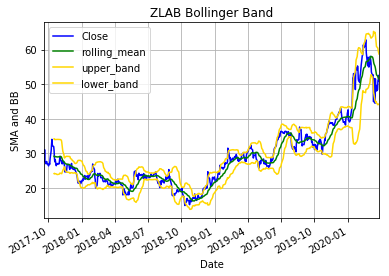

In [90]:
plot_bolling_band(zlab, symbol='ZLAB')

In [10]:
zlab.set_index('Date', inplace=True)
mpf.plot_day_summary_ohlc(zlab[['Open', 'High', 'Low', 'Close']], ticksize = 4, colorup='#77d879', colordown='#db3f3f')

TypeError: plot_day_summary_ohlc() missing 1 required positional argument: 'quotes'

AttributeError: module 'mplfinance' has no attribute 'candlestick2_ohlc'

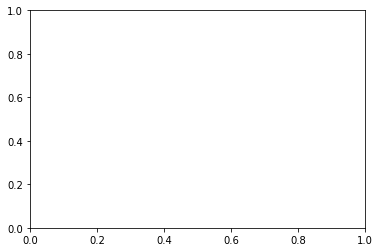

In [19]:
fig, ax = plt.subplots()



In [20]:
import sys

In [37]:
# https://towardsdatascience.com/python-stock-analysis-candlestick-chart-with-python-and-plotly-e619143642bb

fig = go.Figure(data=[
    go.Candlestick(x    = zlab['Date'],
                   open = zlab['Open'],
                   high = zlab['High'],
                   low  = zlab['Low'],
                   close= zlab['Close'])
])

# Add 
movingaverage = go.Scatter(x=zlab['Date'],
                  y=zlab['rolling_mean'],
                  mode="lines",
                  line=go.scatter.Line(color='khaki', width = 1),
                  showlegend=False)

fig.add_trace(movingaverage)

# Bollinger Bands

bbup = go.Scatter(x=zlab['Date'],
                  y=zlab['upper_band'],
                  mode="lines",
                  line=go.scatter.Line(color='khaki', width = 1),
                  showlegend=False)

fig.add_trace(bbup)

bblw = go.Scatter(x=zlab['Date'],
                  y=zlab['lower_band'],
                  mode="lines",
                  line=go.scatter.Line(color='khaki', width = 1),
                  showlegend=False)

fig.add_trace(bblw)

fig.update_layout(
    title={
        'text': 'ZLAB',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
  },
  font=dict(family="Courier New, monospace",
            size=20,
            color="#7f7f7f"),
  template="plotly_white",

  showlegend = False
)


fig.show()